In [12]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

from utils.funs import zetas, frobenious_norm

from transformers import AutoModel, BertModel, DistilBertModel

In [13]:
def getzetasBERT(d,l,h,dh,model):

    normList = np.zeros((l,h))  
    zetaList = np.zeros((l,h))
    
    # retrieve all BertLayer instances (the encoder in each layer)
    layers = model.encoder.layer

    for i, layer in enumerate(layers):

        # access self-attention module within layer
        self_attention = layer.attention.self

        # access W_q and W_k: transpose the weight matrix and split into heads
        Wq = self_attention.query._parameters["weight"].T.view(d,h,dh).detach().numpy()
        Wk = self_attention.key._parameters["weight"].T.view(d,h,dh).detach().numpy()

        for j in range(h):
            
            zetaList[i,j] = zetas(Wq[:,j,:], Wk[:,j,:])
            normList[i,j] = frobenious_norm(Wq[:,j,:], Wk[:,j,:])

    return  zetaList, normList

def getzetasDistillBERT(d,l,h,dh,model):

    normList = np.zeros((l,h))
    zetaList = np.zeros((l,h))

    # retrieve all BertLayer instances (the encoder in each layer)
    layers = model.transformer.layer

    for i, layer in enumerate(layers):

        # access self-attention module within layer
        self_attention = layer.attention

        # access W_q and W_k: transpose the weight matrix and split into heads
        Wq = self_attention.q_lin._parameters["weight"].T.view(d,h,dh).detach().numpy()
        Wk = self_attention.k_lin._parameters["weight"].T.view(d,h,dh).detach().numpy()

        for j in range(h):
            
            zetaList[i,j] = zetas(Wq[:,j,:], Wk[:,j,:])
            normList[i,j] = frobenious_norm(Wq[:,j,:], Wk[:,j,:])

    return  zetaList, normList

In [14]:
"""
- KEY (str): model name
- VALUES (list): [layers (int), 
                  embedding dim (int), 
                  heads (int), 
                  head dim (int), 
                  S scores, 
                  N scores]
"""

if os.path.isfile('../../_data/fig_zetas/BERT.pkl'):
    with open('../../_data/fig_zetas/BERT.pkl', 'rb') as file:
        models = pickle.load(file)
else: models = {}

In [23]:
""" 
BERT models 
 - MODEL: Bidirectional, Encoder-only Transformer
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)
 - METRICS: perplexity, cross-entropy

 MLM: randomly masked some words in the sentence, predict masked words with cross-entropy 
 over the vocabulary 
 NSP: 

The idea is that these models have a better understanding of context, where each word is represented as a 
linear combination of all the other words in the sentence, bi-directionally.
"""
dh = 64

'BERT tiny (l = 2, d = 128, h = 2 ; 4.40M parameters)'
l = 2
d = 128
h = d // dh
model = AutoModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
zeta, norm = getzetasBERT(d,l,h,dh,model)
models['BERTtiny'] = [l,d,h,dh,zeta,norm]

'BERT mini (l = 4, d = 256, h = 4 ; 11.3M parameters)'
l = 4
d = 256
h = d // dh
model = AutoModel.from_pretrained("google/bert_uncased_L-4_H-256_A-4")
zeta, norm = getzetasBERT(d,l,h,dh,model)
models['BERTmini'] = [l,d,h,dh,zeta,norm]

'BERT small (l = 4, d = 512, h = 8 ; 29.1M parameters)'
l = 4
d = 512
h = d // dh
model = AutoModel.from_pretrained("google/bert_uncased_L-4_H-512_A-8")
zeta, norm = getzetasBERT(d,l,h,dh,model)
models['BERTsmall'] = [l,d,h,dh,zeta,norm]

'BERT medium (l = 8, d = 512, h = 8 ; 41.7M parameters)'
l = 8
d = 512
h = d // dh
model = AutoModel.from_pretrained("google/bert_uncased_L-8_H-512_A-8")
zeta,norm = getzetasBERT(d,l,h,dh,model)
models['BERTmedium'] = [l,d,h,dh,zeta,norm]

'BERT base (l = 12, d = 768, h = 12 ; 110M parameters)'
l = 12
d = 768
h = d // dh
model = BertModel.from_pretrained("bert-base-uncased")
zeta, norm = getzetasBERT(d,l,h,dh,model)
models['BERTbase'] = [l,d,h,dh,zeta,norm]

'BERT large (l = 24, d = 1024, h = 16 ; 340M parameters)'
l = 24
d = 1024
h = d // dh
model = BertModel.from_pretrained("bert-large-uncased")
zeta, norm = getzetasBERT(d,l,h,dh,model)
models['BERTlarge'] = [l,d,h,dh,zeta,norm]

'BERT large (masking) (l = 24, d = 1024, h = 16 ; 340M parameters)'
l = 24
d = 1024
h = d // dh
model = BertModel.from_pretrained("bert-large-uncased-whole-word-masking")
zeta, norm = getzetasBERT(d,l,h,dh,model)
models['BERTlarge_mask'] = [l,d,h,dh,zeta,norm]

'DistillBERT base model (l = 6, d = 768, h = 12 ; tot num parameters 66M)'
l = 6
d = 768
h = d // dh
model = DistilBertModel.from_pretrained("distilbert-base-uncased")
zeta, norm = getzetasDistillBERT(d,l,h,dh,model)
models['DistillBERT'] = [l,d,h,dh,zeta,norm]

'save'
with open('../../_data/fig_zetas/BERT.pkl', 'wb') as file:
    pickle.dump(models, file)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'BERTtiny'),
  Text(1, 0, 'BERTmini'),
  Text(2, 0, 'BERTsmall'),
  Text(3, 0, 'BERTmedium'),
  Text(4, 0, 'BERTbase'),
  Text(5, 0, 'BERTlarge'),
  Text(6, 0, 'BERTlarge_mask'),
  Text(7, 0, 'DistillBERT')])

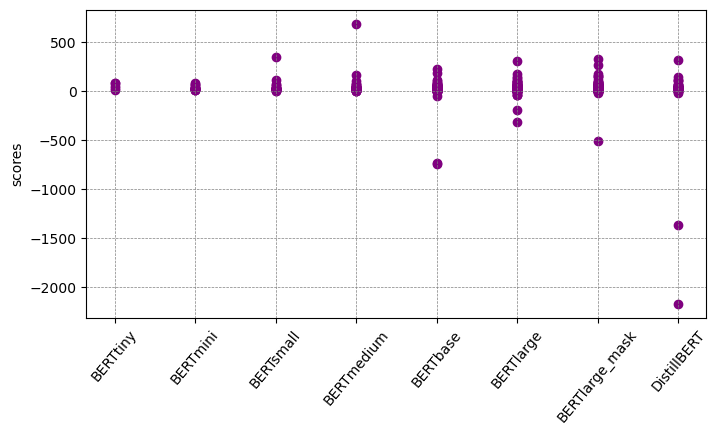

In [24]:
with open('../../_data/fig_zetas/BERT.pkl', 'rb') as file:
    models = pickle.load(file)

zetaList = [models[key][-2].flatten() for key in list(models.keys())]
normList = [models[key][-1].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(8,4))

for i, model in enumerate(zetaList):
    
    plt.scatter(i*np.ones(zetaList[i].size), zetaList[i].flatten(),color='purple',alpha=1)
    plt.scatter(i,(zetaList[i].flatten()).mean(),color='purple')
    
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylabel('scores')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation=50)

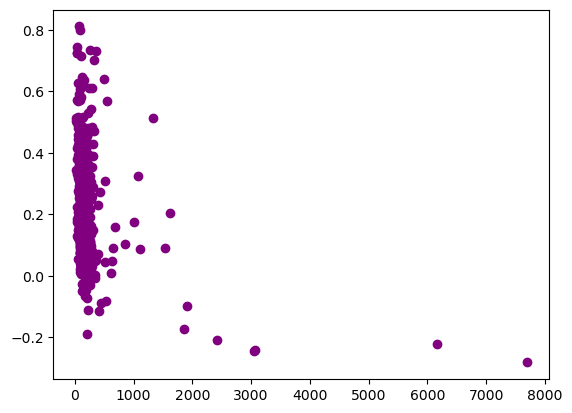

In [29]:
for i, model in enumerate(zetaList):
    
    plt.scatter(normList[i].flatten(), zetaList[i].flatten() / normList[i].flatten(), color='purple')